In [100]:
# Función que procesa el data_frame original como entrada 
# al modelo ya entrenado. 

def transform (df,rename=False,scaler=True):
    # 1. Se renombran las columnas originales 
    if rename:
        df = df.rename(columns={'y': 'deposit','cons.price.idx':'ipc','default':'debts','housing':'mortgage',
                       'duration':'call_duration','campaign':'n_contacts','previous':'n_past_contacts',
                        'poutcome':'previous_results', 'pdays': 'days_from_last_campaign','cons.conf.idx':'icc',
                        'nr.employed':'n_employed','emp.var.rate':'emp_var_rate'})
    
    # 2. Se filtran las numéricas para su estandarización posterior
    df_numerical = df.select_dtypes(exclude="object") 
    
    # 3. Se eliminan aquellas variables numéricas que no aportan valor predictivo. 
    df.drop(['emp_var_rate', 'n_employed','call_duration'], axis = 1, inplace=True)
    df_numerical = list(set(df_numerical) - set(['emp_var_rate', 'n_employed','call_duration']))
    
    # 4. Se binariza la variable target deposit
    binarize_n = {'yes':  1, 'no': 0} 
    df['deposit_n'] = df['deposit'].map(binarize_n)
    
    # 5. Se codifican las variables debts, mortgage y loan mediante el método LabelEncoder
    #coding_n = {'unknown': 0, 'yes': 1, 'no': 2}
    from sklearn. preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(df.debts)
    le.fit(df.mortgage)
    le.fit(df.loan)
    df['debts_n'] = le.transform(df.debts)
    df['mortage_n'] = le.transform(df.mortgage)
    df['loan_n'] = le.transform(df.loan)

    # 6. Se codifican los meses del 1 al 12 secuencialmente 
    coding_mon = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec':12}
    df['month_n'] = df['month'].map(coding_mon)

    # 7. Se codifica las variables contact y previous_results según la siguiente codificación
    coding_contactd_cont = {'unknown': 0, 'cellular': 1, 'telephone': 2}
    df['contact_n'] = df['contact'].map(coding_contactd_cont)
    coding_previous_results = {'nonexistent':0, 'failure':1, 'success':2}
    df['previous_results_n'] = df['previous_results'].map(coding_previous_results)

    # 8. Se codifica el resto de variables como one hot encoding : job, marital, education y day_of_week, 
    df = pd.get_dummies(df, columns = ['job', 'marital', 'education', 'day_of_week'],drop_first=True)
    
    # 9. Se eliman algunas variables ya codificadas
    df = df.drop(['deposit', 'debts','mortgage', 'loan','month', 'contact', 'previous_results'], axis = 1)
    
    # 10. Se estandariza todas las variables numéricas
    if scaler:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        #scaler = MinMaxScaler()
    
        df[df_numerical] = scaler.fit_transform(df[df_numerical])
    
    # 11. Se retorna el data_frame procesado.
    return df

In [7]:
# Se carga en memoria el dataframe original. 
# Es importante que se realimente para su actualización. 
# Por último se visualiza para comprobar su correcta carga en memoria
import pandas as pd
url='bank-additional-full.csv'
df_ref = pd.read_csv(url,sep=";")
df_ref.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Servicio que realiza predicción sobre una petición 
# mediante formulario

# 1. Se importan todas las librerías necesarias para implementar dicho servicio
from flask import Flask, request, jsonify, render_template 
import joblib # Se utiliza joblib para leer el modelo pre-entrenado
import pandas as pd

# 2. Se crea la instancia de Flask
app = Flask(__name__)

# 3. Se abre el archivo que contiene el modelo
MODEL_BANK_TEST = joblib.load('new_model_try2.pkl')
# 4. Se crean las etiquetas con las cuales se clasificaran nuevos datos
# Sabemos que se corresponde con la denegación o concesión del depósito. 

MODEL_LABELS_BANK =['no','yes']
"""
El método predict sera el encargado de clasificar y dar una respuesta
a cualquier IP que le envie una petición.
"""
# 5. Recurso que sólo captura los datos del formulario. 
@app.route('/form1')
def form1():
    return render_template('form1.html')

# 6. Recurso que genera una predicción medainte la recogida de datos de entrada
# a través de un formulario. 
@app.route('/form1+', methods=['POST','GET'])
def form1_():
    if request.method == "GET":
        return render_template('form1.html')
    # 7. Obtiene los datos del formulario en modo diccionario mediante el método request
    elif request.method== 'POST':
        data = request.form.to_dict()
        # 8. Se visualiza el diccionario de entrada. 
        print(data)
        print(data.keys())
        print(data.values())
        # 9. Conversión de datos adecuada de las variables numéricas
        data['age']= int(data['age'])
        data['campaign'] = int(data['campaign'])
        data['pdays'] = int(data['pdays'])
        data['previous'] = int(data['previous'])
        data['emp.var.rate'] = float(data['emp.var.rate'])
        data['cons.price.idx']= float(data['cons.price.idx'])
        data['cons.conf.idx']= float(data['cons.conf.idx'])
        data['euribor3m'] = float(data['euribor3m'])
        data['nr.employed'] = float(data['nr.employed'])
        # 10. Se formatea adecuadamente el nuevo registro para añadirlo al dataframe original
        
        #data2={'contact': 'cellular', 'month': 'oct', 'day_of_week': 'fri', 'campaign': 1, 'pdays': 3, 'previous': 1,
        # 'poutcome': 'success', 'age': 25, 'job': 'student', 'marital': 'single', 'education': 'high.school', 'default': 'no', 
        #'housing': 'yes','loan': 'no', 'emp.var.rate': -1.1, 'cons.price.idx': 94.601, 'cons.conf.idx': -49.5, 
        # 'euribor3m': 1.029, 'nr.employed': 4963.6}
        data2={'contact': data['contact'], 'month': data['month'], 'day_of_week': data['day_of_week'], 
        'campaign': data['campaign'], 'pdays': data['pdays'], 'previous': data['previous'],'poutcome': data['poutcome'],
        'age': data['age'], 'job': data['job'],'marital': data['marital'], 'education': data['education'], 
        'default': data['default'], 'housing': data['housing'],'loan': data['loan'],
        'emp.var.rate': data['emp.var.rate'], 'cons.price.idx': data['cons.price.idx'],
        'cons.conf.idx':data['cons.conf.idx'] ,'euribor3m': data['euribor3m'], 'nr.employed': data['nr.employed']}
        
        # 11. Se añade nuevo dato al dataframe original
        df1= df_ref.append(data2,ignore_index=True)                
        
        # 12. Se procesa adecuadamente para alimentar al modelo ya entrenado
        rename=True
        df2 =transform(df1,rename)
        # 13. Se obtiene el último registro correspondiente del formulario ya entrenado. 
        df2 = df2.drop('deposit_n', axis = 1)
        x1=df2.tail(1)
        
        # 14. Se visualiza el resgistro procesado junto con sus columnas
        print(x1)
        x1.columns
        
        # 15. Se realiza dicha predicción. 
        label_index = MODEL_BANK_TEST.predict(x1)
    
        """
        La variable label contendra el resultado de la clasificación.
        """
        # 16. Se obtiene la etiqueta de dicha predicción 
        label = MODEL_LABELS_BANK[label_index[0]]
    
        # 17. Se crea y se envía la respuesta al cliente
        return jsonify(status='Predicción Completada', prediccion=label)
        #return "Formulario recibido"
    else:
        return "Método no aceptado"
    
# 18. Recurso de página no encontrada 
@app.errorhandler(404)
def page_not_found(error):
    return render_template('page_not_found.html'),404

# Se inicia y se pone a la escucha el servidor. 
if __name__ == '__main__':
    
    app.run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


In [23]:
## Algoritmo Knn K-nearest neighbor)
# Calcula las distancias teniendo en cuenta las k features más cercanas.

# split train, test
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn import metrics
rename=True
df2 =transform(df_ref,rename)
y = df2['deposit_n']
x = df2.drop('deposit_n', axis = 1)

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)

error_rate = []
acc = []
for i in range(1,40):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(x_train, y_train)
     pred_i = knn.predict(x_test)
     error_rate.append(np.mean(pred_i != y_test))
     acc.append(metrics.accuracy_score(y_test, pred_i))



Minimum error:- 0.10119452267650772 at K = 33


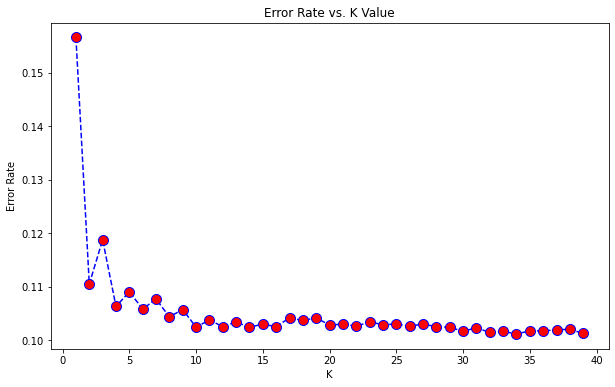

In [24]:
# Visualising the tuning parameters
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.8988054773234923 at K = 33


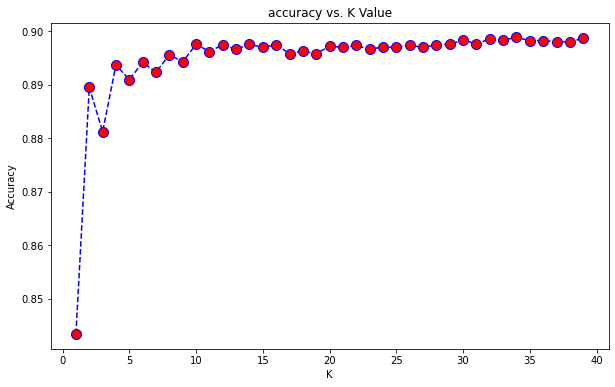

In [25]:
# Se visualiza el accuracy
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [40]:
# Train model using hyperparmeter tuning
def training_model_hyperparameter(model, scoring, params_grid, X_train, y_train):
    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=100)

    grid = GridSearchCV(estimator = model, scoring=scoring, param_grid = params_grid, cv = folds, 
                           verbose=0, return_train_score=True, n_jobs=3)
    grid.fit(X_train, y_train)
    return grid
# A continuación se estudia el modelo ensamblado bagging que cosiste
# en entrenar varios árboles con un subconjunto de datos utilizando 
# todas las variables predictoras # bagging classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(  criterion='gini'),
    )

model = BaggingClassifier(base_estimator = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=25, max_depth=8, criterion='gini'),
                          )

params_grid_bg = {
    'base_estimator__max_depth' : [3, 4, 5,6,7,8],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]

}
gb_grid = training_model_hyperparameter(model_bagging, 'roc_auc', params_grid_bg, x_train, y_train)


In [41]:
gb_grid.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                  max_samples=0.5)

In [86]:
# Oversampling.
# Se obtiene más muestras obtienendo un dataset más balanceado.
#!pip install imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
print('Tamaño original de entrenamiento', len(x_train))
print('Tamaño remuestreado de entrenamiento', len(x_smote))

Tamaño original de entrenamiento 30891
Tamaño remuestreado de entrenamiento 54808


C:\Users\rmsalvador\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


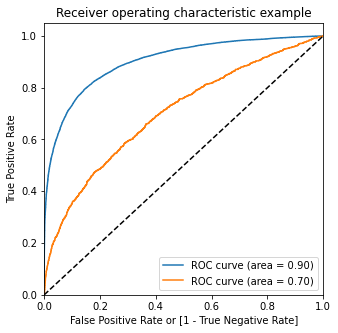

Accuracy train:  0.8240767771128302
Accuracy test:  0.7962513353403904


In [87]:
#!pip install import_ipynb
import import_ipynb
import functions
from sklearn.metrics import accuracy_score
#%run functions.ipynb

logreg = LogisticRegression(solver='lbfgs', random_state = 100)
#logreg = logreg.fit(x_train, y_train)
logreg = logreg.fit(x_smote, y_smote)

#y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_train, y_train, x_test, y_test)
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_smote, y_smote, x_test, y_test)

#%run functions.ipynb

#draw_roc(y_train, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)
draw_roc(y_smote, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)

#print("Accuracy train: ", accuracy_score(y_train, y_train_pred_lr))
#print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))

print("Accuracy train: ", accuracy_score(y_smote, y_train_pred_lr))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))


### SMOTE
Técnica Over-sampling basado en los k-nearest vecinos de la clase minorista   

In [91]:
from matplotlib import pyplot as plt
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [90]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_smt, y_smt = smt.fit_resample(x_train, y_train)



NameError: name 'plot_2d_space' is not defined

In [93]:
#plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')
X_smt

,age,n_contacts,days_from_last_campaign,n_past_contacts,ipc,icc,euribor3m,debts_n,mortage_n,loan_n,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,0.957281,-0.565922,0.195414,-0.349494,0.722722,0.886447,0.712460,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,-1.345734,0.517118,0.195414,-0.349494,0.722722,0.886447,0.711307,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,-0.578062,0.156105,0.195414,-0.349494,-0.227465,0.951267,0.774152,0,2,0,...,0,1,0,0,0,0,0,1,0,0
3,-0.961898,-0.565922,0.195414,-0.349494,0.722722,0.886447,0.711307,0,2,0,...,1,0,0,0,0,0,0,0,0,0
4,-1.057857,-0.204909,0.195414,-0.349494,-0.649003,-0.323542,0.262167,0,2,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54519,-0.285680,-0.565922,0.195414,-0.349494,-0.227465,0.951267,0.773161,0,0,0,...,0,0,0,0,1,0,0,1,0,0
54520,1.940732,-0.565922,0.195414,-0.349494,-1.058448,-0.064259,-1.361050,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54521,-1.268311,0.947868,0.195414,-0.349494,0.591424,-0.474791,0.770814,0,2,0,...,1,0,0,0,0,0,0,0,0,0
54522,-1.057857,-0.428932,-5.123433,1.671136,-2.011627,2.701337,-1.658250,0,2,0,...,0,1,0,0,0,0,0,0,0,0


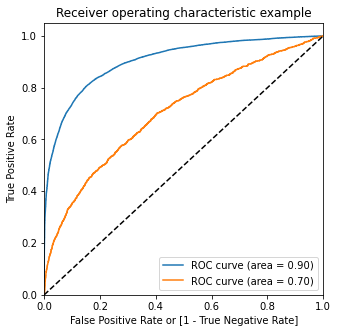

Accuracy train:  0.8273604284351845
Accuracy test:  0.7962513353403904


In [97]:
import import_ipynb
import functions
from sklearn.metrics import accuracy_score
#%run functions.ipynb

logreg = LogisticRegression(solver='lbfgs', random_state = 100, max_iter = 1000)
#logreg = logreg.fit(x_train, y_train)
logreg = logreg.fit(X_smt, y_smt)
#X_smt, y_smt
#y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_train, y_train, x_test, y_test)
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, X_smt, y_smt, x_test, y_test)

#%run functions.ipynb

#draw_roc(y_train, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)
draw_roc(y_smt, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)

#print("Accuracy train: ", accuracy_score(y_train, y_train_pred_lr))
#print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))

print("Accuracy train: ", accuracy_score(y_smt, y_train_pred_lr))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))

In [158]:
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import import_ipynb
import functions
from sklearn.metrics import accuracy_score

smote = SMOTE()

url='bank-additional-full.csv'
df_ref = pd.read_csv(url,sep=";")
df_ref.head()



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


LOGISTIC REGRESSION MODEL
              precision    recall  f1-score   support

          no       0.97      0.93      0.95      9558
         yes       0.93      0.97      0.95      8716

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



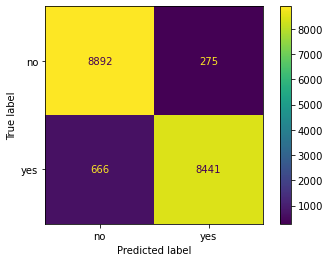

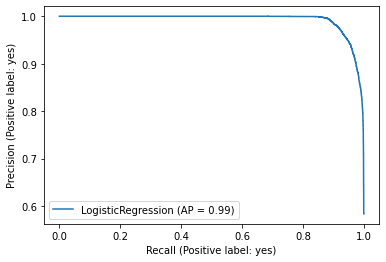

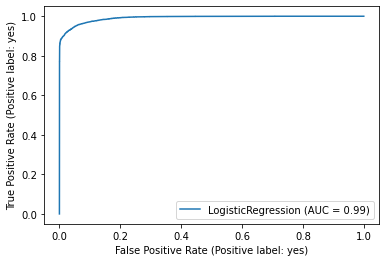

In [167]:
rename=True
scaler=False

x=df_ref.drop(['y'],axis=1)
x=pd.get_dummies(x)
y=df_ref['y']
#df2 =transform(df_ref,rename,scaler)
#y = df2['deposit_n']
#x = df2.drop('deposit_n', axis = 1)

x, y = smote.fit_resample(x, y)
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)




logreg = LogisticRegression(solver='liblinear', random_state = 100)
logreg = logreg.fit(x_train, y_train)

from sklearn.metrics import plot_confusion_matrix,classification_report,plot_precision_recall_curve,plot_roc_curve

def report(model):
    preds = model.predict(x_test)
    print(classification_report(preds,y_test))
    plot_confusion_matrix(model,x_test,y_test)
    plot_precision_recall_curve(model,x_test,y_test)
    plot_roc_curve(model,x_test,y_test)

    
print("LOGISTIC REGRESSION MODEL")
report(logreg)

In [168]:
x


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73091,49,893,2,999,0,1.100000,93.994000,-36.400000,4.857110,5191.000000,...,0,0,1,0,0,0,0,0,1,0
73092,36,542,1,999,0,-0.100000,93.200000,-42.000000,4.159151,5195.800000,...,0,0,0,0,0,0,0,0,1,0
73093,55,406,1,999,0,-2.900000,92.318456,-32.364191,0.947777,5076.200000,...,0,0,0,0,0,0,0,0,1,0
73094,30,134,1,8,1,-2.274324,93.090928,-32.458025,0.667238,5011.308782,...,0,0,0,0,0,0,0,0,0,1


In [169]:
x.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oc

In [170]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
73091    yes
73092    yes
73093    yes
73094    yes
73095    yes
Name: y, Length: 73096, dtype: object

Accuracy train:  0.9498558972675203
Accuracy test:  0.9485060742037869


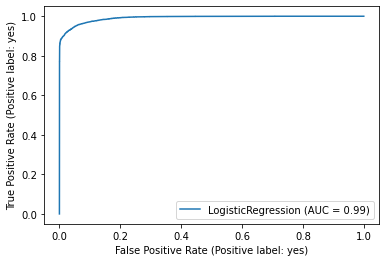

In [171]:
#y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_train, y_train, x_test, y_test)

x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_train, y_train, x_test, y_test)

#%run functions.ipynb

#draw_roc(y_train, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)
plot_roc_curve(logreg,x_test,y_test)
print("Accuracy train: ", accuracy_score(y_train, y_train_pred_lr))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))




In [164]:
y_train

549       no
1974      no
20992     no
1730      no
26913     no
        ... 
6265      no
11284     no
38158    yes
860       no
15795     no
Name: y, Length: 30891, dtype: object

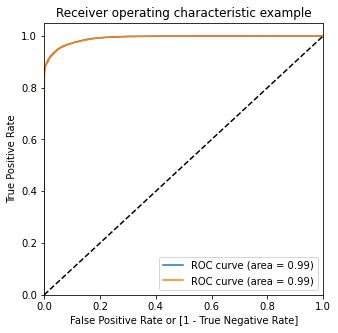

Accuracy train:  0.949874138119733
Accuracy test:  0.9491080223268031


In [176]:
x=df_ref.drop(['y'],axis=1)
x=pd.get_dummies(x)
y=df_ref['y']
binarize_n = {'yes':  1, 'no': 0} 
y = y.map(binarize_n)
#df2 =transform(df_ref,rename,scaler)
#y = df2['deposit_n']
#x = df2.drop('deposit_n', axis = 1)

x, y = smote.fit_resample(x, y)
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
logreg = LogisticRegression(solver='lbfgs', random_state = 100,max_iter = 1000)

logreg = logreg.fit(x_train, y_train)


y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr,y_test_pred_lr_prob= prediction_model(logreg, x_train, y_train, x_test, y_test)

#%run functions.ipynb

draw_roc(y_train, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)


print("Accuracy train: ", accuracy_score(y_train, y_train_pred_lr))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred_lr))